In [2]:
#GETTING DATASETS,PREPARING DATA AND IMPORTS
from mpl_toolkits.basemap import Basemap
from pyspark.mllib.stat import Statistics
from datetime import datetime
from collections import defaultdict
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time
import operator
from IPython.display import clear_output
 

%matplotlib inline

path_file = "../../data/chicagocrimedata.csv"
raw_data = sc.textFile(path_file)
data_header = raw_data.first()
header_fields = 'Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,Ward,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude,Location'
data = raw_data.filter(lambda x: header_fields not in x).map(lambda x: x.split(","))

policestation_data = sc.textFile("../../data/policestations.csv").filter(lambda x: 'DISTRICT,DISTRICT NAME,ADDRESS,CITY,STATE,ZIP,WEBSITE,PHONE,FAX,TTY,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION' not in x).map(lambda x: x.split(","))

#CONSTANTE
#primary charges 
AST = 'ASSAULT'
CSA = 'CRIM SEXUAL ASSAULT'
KDP = 'KIDNAPPING'
ROB = 'ROBBERY'
ONV = 'OTHER NARCOTIC VIOLATION'
SXO = 'SEX OFFENSE'
PROS = 'PROSTITUTION'
MVT = 'MOTOR VEHICLE THEFT'
LLV = 'LIQUOR LAW VIOLATION'
CRT = 'CRIMINAL TRESPASS'
OTF = 'OTHER OFFENSE'
GAM ='GAMBLING'
BURG ='BURGLARY'
HMC ='HOMICIDE'
STALK ='STALKING'
NONC ='NON-CRIMINA'
OIC ='OFFENSE INVOLVING CHILDREN'
OBC ='OBSCENITY'
DEP ='DECEPTIVE PRACTICE'
ARS ='ARSON'
PBIN ='PUBLIC INDECENCY'
BATT ='BATTERY'
PPV = 'PUBLIC PEACE VIOLATION'
IWPO = 'INTERFERENCE WITH PUBLIC OFFICER'
NARC = 'NARCOTICS'
CRIMD = 'CRIMINAL DAMAGE'
INTIM = 'INTIMIDATION'
THF = 'THEFT'
WPV = 'WEAPONS VIOLATION'

In [7]:
#Welke type moorde werd het meest gepleegd 
crimes_data = data.map(lambda x: x[4])

d = dict()

for item in crimes_data.collect():    
    if item in d:
        d[item] += 1
    else:
        d[item] = 1


In [18]:
#data filter functions

def getDataByCrimeAndYear(crime,year):
    return data.filter(lambda x: x[14] == str(year)).filter(lambda x: x[4] == crime).collect()

def getDataByCrime(crime):
    return data.filter(lambda x: x[4] == crime).collect()

def getDataByYear(year):
    return data.filter(lambda x: x[14] == str(year)).collect()

In [9]:
#Get all fields with murder in it 
homicide_data = data.filter(lambda x: HMC in x)

#1. waarvan er arrestaties plaatsvonden
arrest_count = homicide_data.map(lambda x: x[7]).filter(lambda x: 'true' in x).count()

#2. waarvan huishoudelijk geweld
domestic_count = homicide_data.map(lambda x: x[8]).filter(lambda x: 'true' in x).count()

#totaal arrestaties
labels_arrest = ['Open cases', 'Arrest made']
fracs_arrest = [d[HMC], arrest_count]
explode = [0, 0.10]

#totaal huishoudelijke met als moord als gevolg
label_domestic = ['Non domestic', 'Domestic']
fracs_domestic = [d[HMC], domestic_count]


'Van alle {0} moorden werden {1} arrestaties gemaakt waarvan er {2} huishoudelijke geweld'.format(d[HMC], arrest_count, domestic_count)


'Van alle 898 moorden werden 407 arrestaties gemaakt waarvan er 67 huishoudelijke geweld'

([<matplotlib.patches.Wedge at 0x12c1fba8>,
 [<matplotlib.text.Text at 0xd0aedd8>, <matplotlib.text.Text at 0xe3a3a20>],
 [<matplotlib.text.Text at 0xe3a3128>, <matplotlib.text.Text at 0xe3a3d30>])

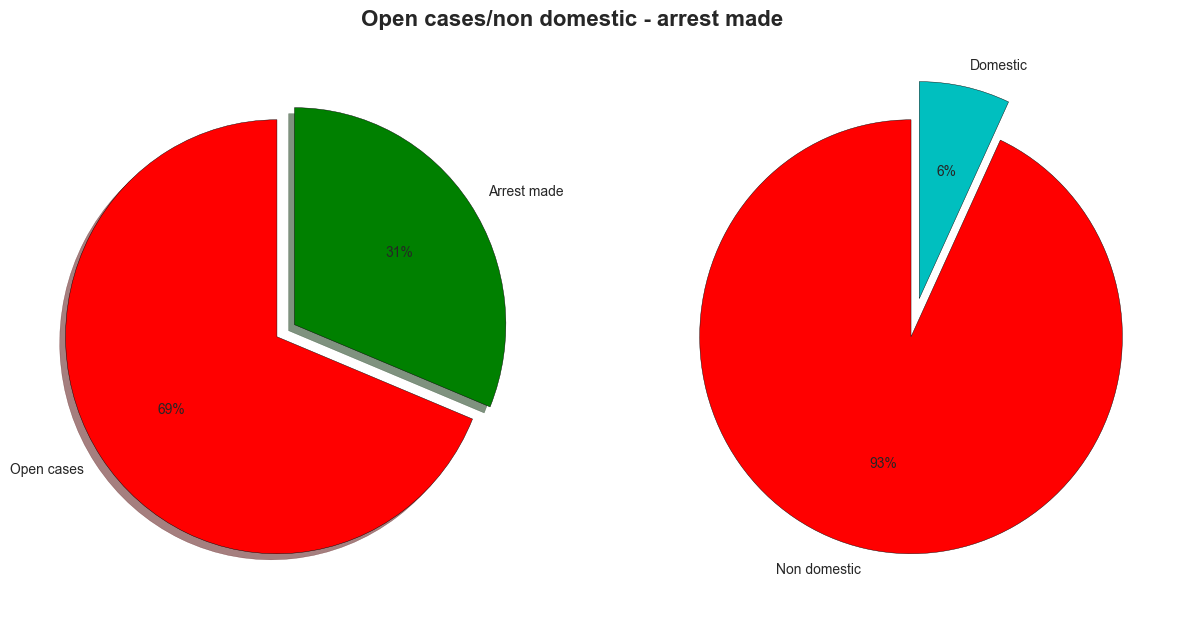

In [10]:
# draw the charts 
#Wij maken hier geen gebruik van de make_pie_chart functie omdat wij de chart naast elkaar willen hebben 

#arrestatie vs moord pie chart
fig = plt.figure(figsize=(15, 7))
fig.suptitle('Open cases/non domestic - arrest made ', fontsize=16, fontweight='bold')

ax_arrest = fig.add_subplot(121)
ax_arrest.pie(fracs_arrest, explode=explode, labels=labels_arrest, colors=('r', 'g'), 
              autopct='%1.0f%%', shadow=True, startangle=90)
#huishoudelijk geweld met als moord als gevolg

ax_dom = fig.add_subplot(122)
ax_dom.pie(fracs_domestic, explode=[0,0.18], labels=label_domestic, colors=('r', 'c'), autopct='%d%%', shadow=False, startangle=90)

In [7]:
#Het char defineren 

#grote misdaden
high_crimes =[d[HMC],d[AST],d[CSA],d[NARC],d[OIC],d[KDP],d[SXO]]

hi_xticklabels =['Homicide', 'Assault', 'Sexual assault', 'narcotics', 'offense involving childrens',
                    'kidnapping','sex offense']

#middelmatige misdaden
med_crimes = [d[PROS],d[GAM],d[ARS],d[ROB],d[THF],d[BATT],d[CRT],d[MVT],d[BURG],d[CRIMD]]

mi_xticklabels =['prostitution','gambling','arson', 'robbery','theft','battery',
                 'tresspassing','motor vehicle theft', 'burglary','criminal damage']

#kleine misdaden
low_crimes =[d[LLV], d[WPV],d[STALK],d[INTIM], d[PPV], d[DEP], d[IWPO]]

low_xticklabels=['Alcohol violation', 'weapon violation', 'stalking', 
                 'intimidation', 'public peace violation', 'deceptive practice', 'interferring with police']
                #other_offence moet hier tussen maar ik weet niet wat dat is
    
def make_bar_char(crimes, n_groups, schuif_ratio, bar_width, opacity, color, error_config, fontsize_x, fontsize_y,
                   x_label, y_label, title, fontsize_title, xticklabels):

    index = np.arange(n_groups)
    fig = plt.figure(figsize=(18,7))
    plt.xticks(fontsize=fontsize_x, fontweight='bold')  
    plt.yticks(fontsize=fontsize_y, fontweight='bold')  
    
    ax = fig.add_subplot(111)
    rects1 =ax.bar(index, crimes, bar_width,
                 alpha=opacity,
                 color=color,
                 linewidth=1,
                 align ='edge',
                 error_kw=error_config)


    ax.set_xlabel(x_label, fontsize=16, fontweight='bold')
    ax.set_ylabel(y_label,  fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize = fontsize_title, fontweight='bold')
    ax.set_xticks(index +schuif_ratio)
    ax.set_xticklabels(xticklabels)
    
        # aantal boven grafiek
    for rect in rects1:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom',
                fontsize=14, 
                fontweight ='bold')

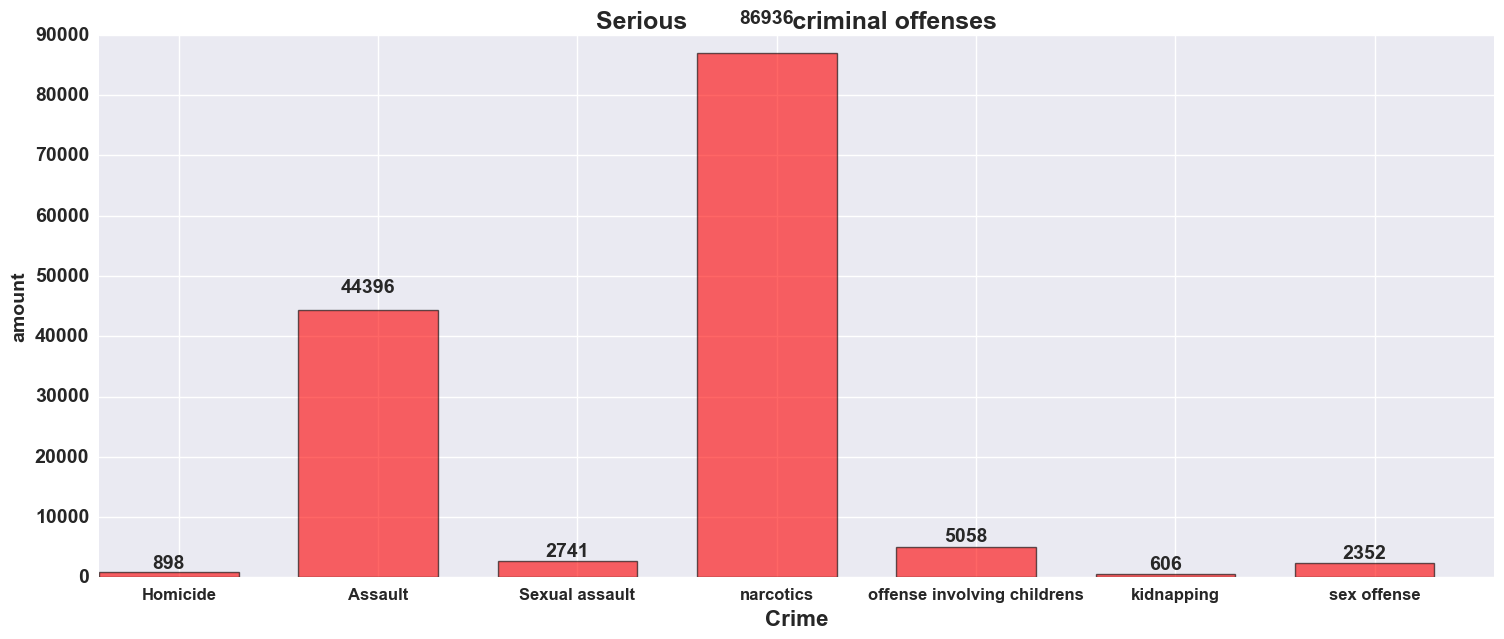

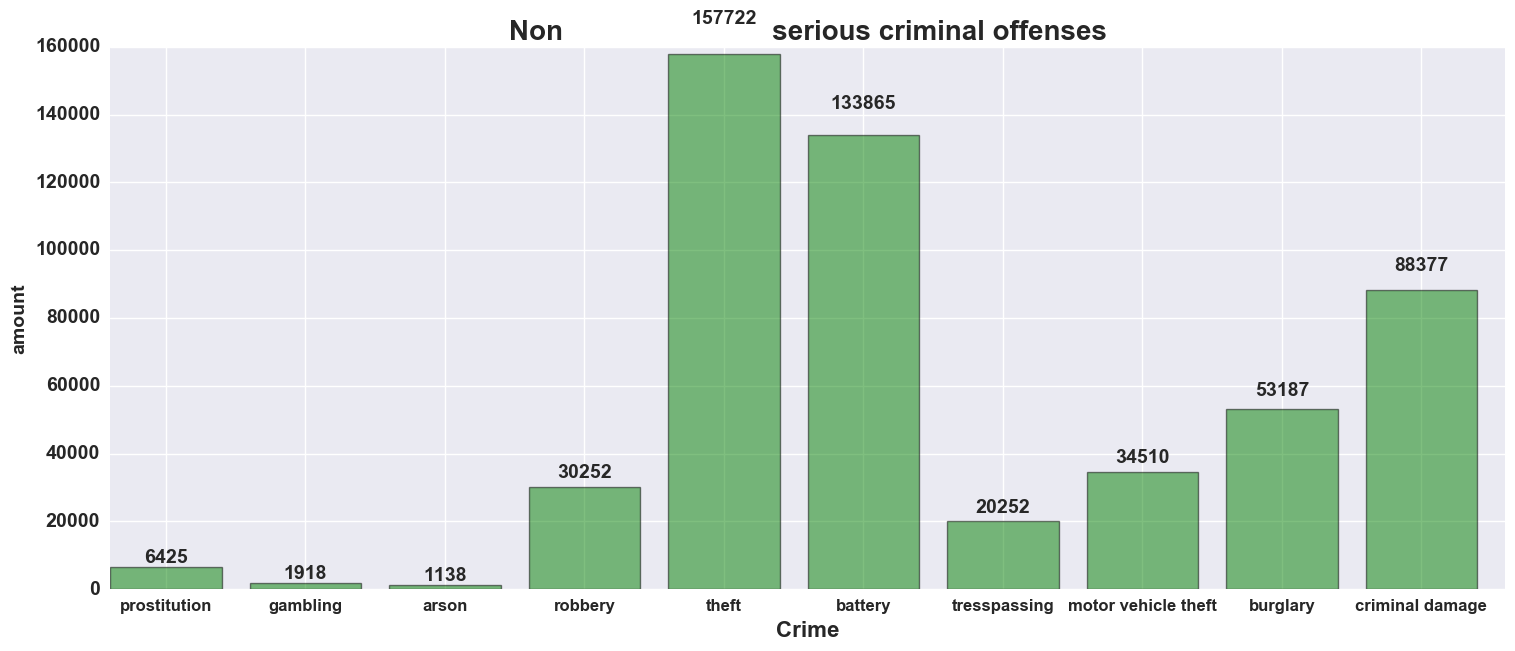

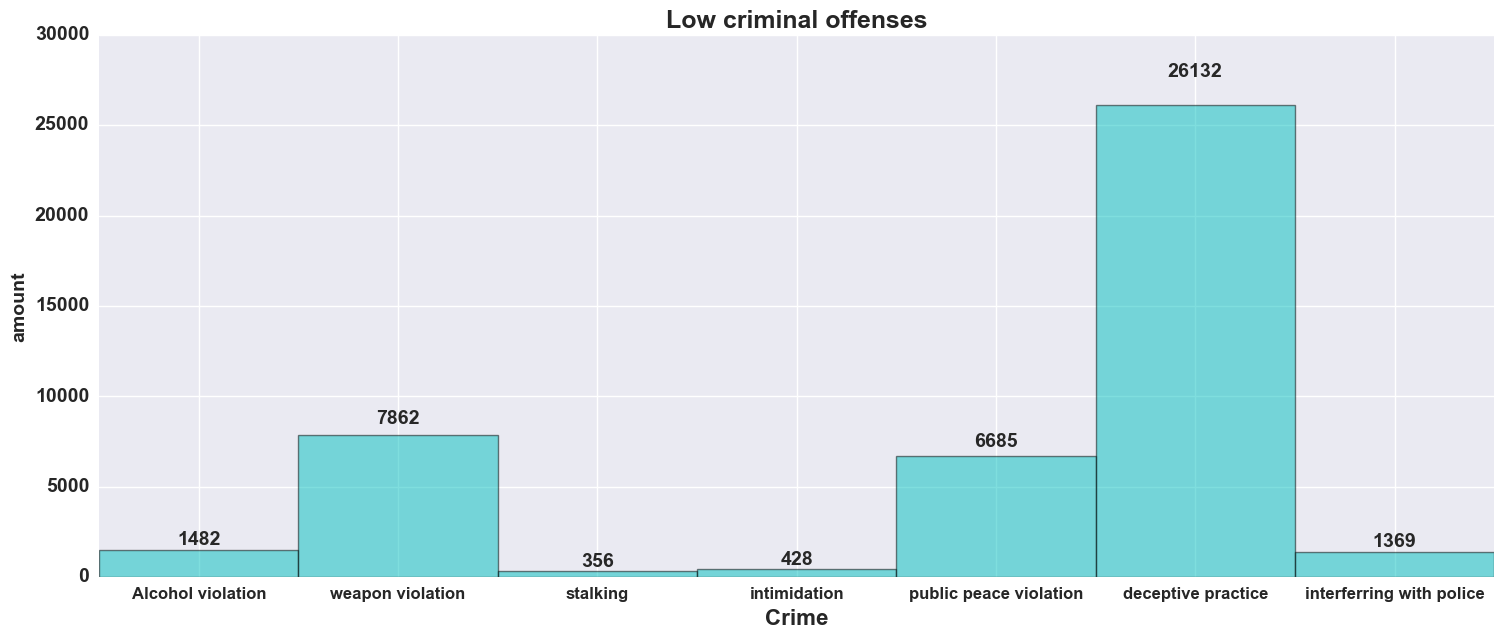

In [8]:
#Bar char tekenen 
"""
parameters : crimes, len(crimes), schuif_rtatio, bar_width, opacity, color, error_config, fontsize_x, fontsize_y
            x_label, y_label, title, fontsize_title, xticklabels 
"""
make_bar_char(high_crimes, len(high_crimes), 0.4, 0.7, 0.6, 'r', {'ecolor': '0.4'}, 12, 14,
              'Crime', 'amount', 'Serious               criminal offenses', 18, hi_xticklabels ) 

make_bar_char(med_crimes, len(med_crimes), 0.4, 0.8, 0.5, 'g', {'ecolor': '0.3'}, 12, 14,
             'Crime', 'amount', 'Non                           serious criminal offenses', 20, mi_xticklabels )  

make_bar_char(low_crimes, len(low_crimes), 0.5, 1, 0.5, 'c', {'ecolor': '0.3'}, 12, 14,
              'Crime', 'amount', 'Low criminal offenses', 18, low_xticklabels )  

In [9]:
# get all serious crimes 
homicide_data= data.filter(lambda x: HMC in x)
assault_data= data.filter(lambda x:  AST in x).filter(lambda x: CSA not in x)
crim_sex_assault_data= data.filter(lambda x: CSA in x)
narcotics_data= data.filter(lambda x: NARC in x)
offense_inv_children_data= data.filter(lambda x: OIC in x)
kidnapping_data= data.filter(lambda x: KDP in x)
sex_offense_data= data.filter(lambda x: SXO in x)

In [12]:
HMC_arrested_count = AST_arrested_count = CSA_arrested_count = NARC_arrested_count = OIC_arrested_count = KDP_arrested_count = SXO_arrested_count = 0
HMC_domestic_count = AST_domestic_count = CSA_domestic_count = NARC_domestic_count = OIC_domestic_count = KDP_domestic_count = SXO_domestic_count = 0

for item in data.collect():    
    if item[4] == HMC:
        if item[7] == 'true':
            HMC_arrested_count+=1
        if item[8] == 'true':
            HMC_domestic_count+=1
            
    elif item[4] == AST:
        if item[7] == 'true':
            AST_arrested_count+=1
        if item[8] == 'true':
            AST_domestic_count+=1
            
    elif item[4] == CSA:
        if item[7] == 'true':
            CSA_arrested_count+=1
        if item[8] == 'true':
            CSA_domestic_count+=1
            
    if item[4] == NARC:
        if item[7] == 'true':
            NARC_arrested_count+=1
        if item[8] == 'true':
            NARC_domestic_count+=1
            
    if item[4] == OIC:
        if item[7] == 'true':
            OIC_arrested_count+=1
        if item[8] == 'true':
            OIC_domestic_count+=1
            
    if item[4] == KDP:
        if item[7] == 'true':
            KDP_arrested_count+=1
        if item[8] == 'true':
            KDP_domestic_count+=1
            
    if item[4] == SXO:
        if item[7] == 'true':
            SXO_arrested_count+=1
        if item[8] == 'true':
            SXO_domestic_count+=1


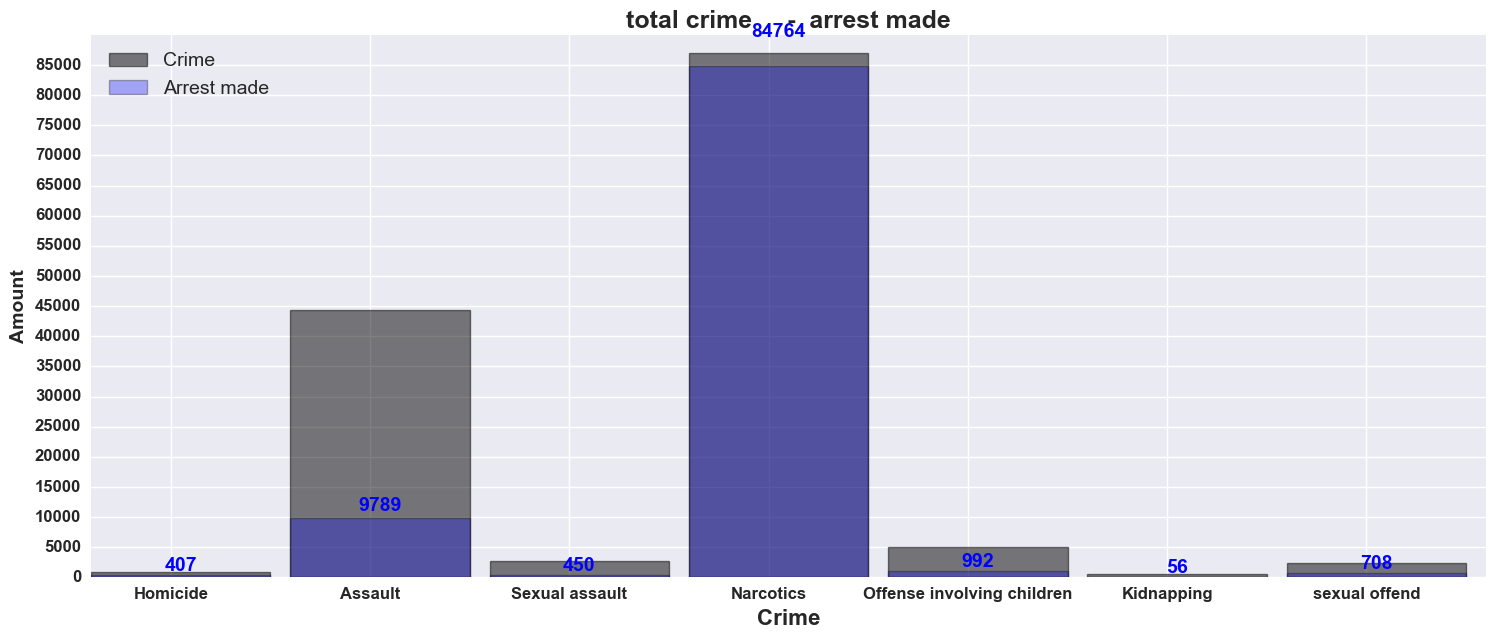

In [13]:
mix_hi_crimes = [d[HMC],d[AST],d[CSA],d[NARC],d[OIC],d[KDP],d[SXO]]

mix_hi_arrest = [HMC_arrested_count,AST_arrested_count,CSA_arrested_count, 
                 NARC_arrested_count,OIC_arrested_count, KDP_arrested_count,SXO_arrested_count]


n_groups = (len(mix_hi_crimes))
index = np.arange(n_groups)

fig = plt.figure(figsize=(18,7))
plt.xticks(fontsize=12, fontweight='bold')  
plt.yticks(fontsize=12, fontweight='bold')  
    
ax = fig.add_subplot(111)
rects1 =ax.bar(index, mix_hi_crimes,
               0.9,
               alpha=0.5,
               color='black',
               linewidth=1,
               align ='edge')
rects2 =ax.bar(index, mix_hi_arrest,
               0.9,
               alpha=0.3,
               color='b',
               linewidth=1,
               align ='edge')

xticklabels =('Homicide','Assault','Sexual assault','Narcotics','Offense involving children','Kidnapping','sexual offend')

ax.set_xlabel('Crime', fontsize=16, fontweight='bold')
ax.set_ylabel('Amount',  fontsize=14, fontweight='bold')
ax.set_title('total crime     -  arrest made', fontsize = 18, fontweight='bold')
ax.set_xticks(index +0.4)
ax.set_xticklabels(xticklabels)

ticks_y = np.arange(0, 90000, 5000)   
ax.set_yticks(ticks_y)  

#extra's : achtergrond kleur, legende
#ax.set_axis_bgcolor('grey')
ax.legend((rects1[0], rects2[0]), ('Crime', 'Arrest made'),prop={'size':14}, loc=2)


    
for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom',
            fontsize=14, 
            fontweight ='bold',
           color ='b')

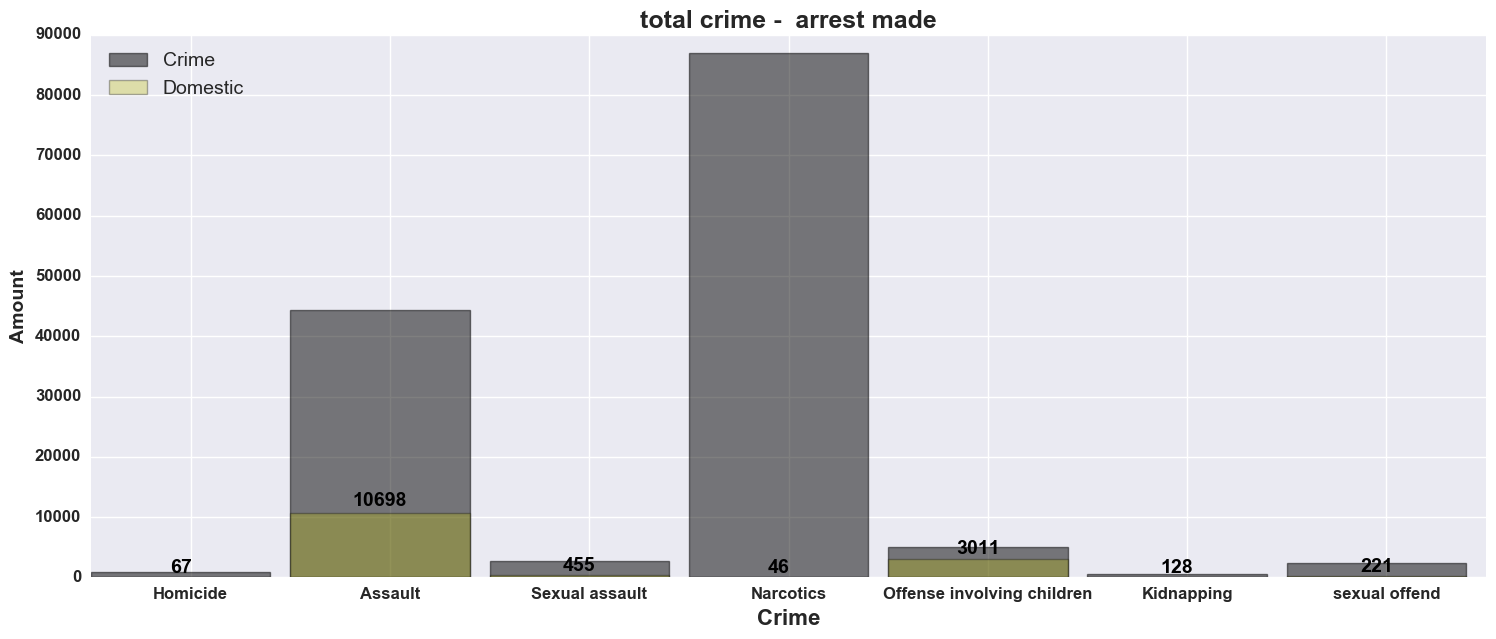

In [12]:
mix_hi_crimes = [d[HMC],d[AST],d[CSA],d[NARC],d[OIC],d[KDP],d[SXO]]

mix_hi_domestic = [HMC_domestic_count,AST_domestic_count,CSA_domestic_count, 
                 NARC_domestic_count,OIC_domestic_count, KDP_domestic_count,SXO_domestic_count]


n_groups = (len(mix_hi_crimes))
index = np.arange(n_groups)

fig = plt.figure(figsize=(18,7))
plt.xticks(fontsize=12, fontweight='bold')  
plt.yticks(fontsize=12, fontweight='bold')  
    
ax = fig.add_subplot(111)
rects1 =ax.bar(index, mix_hi_crimes,
               0.9,
               alpha=0.5,
               color='black',
               linewidth=1,
               align ='edge')
rects2 =ax.bar(index, mix_hi_domestic,
               0.9,
               alpha=0.3,
               color='y',
               linewidth=1,
               align ='edge')

xticklabels =('Homicide','Assault','Sexual assault','Narcotics','Offense involving children','Kidnapping','sexual offend')

ax.set_xlabel('Crime', fontsize=16, fontweight='bold')
ax.set_ylabel('Amount',  fontsize=14, fontweight='bold')
ax.set_title('total crime -  arrest made', fontsize = 18, fontweight='bold')
ax.set_xticks(index +0.5)
ax.set_xticklabels(xticklabels)

#extra's : achtergrond kleur, legende
#ax.set_axis_bgcolor('grey')
ax.legend((rects1[0], rects2[0]), ('Crime', 'Domestic'),prop={'size':14}, loc=2)


    
for rect in rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
            '%d' % int(height),
            ha='center', va='bottom',
            fontsize=14, 
            fontweight ='bold',
           color ='black')

In [13]:
location =data.map(lambda x: x[6])
 
d = defaultdict(lambda:0)
for item in location.collect():    
   d[item]+=1        
 
sorted_locations = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
top10_loc =  sorted_locations[:10]
 
#-------------------
crimes_in_school = data.filter(lambda x: x[6]=='"SCHOOL').map(lambda x: x[4])
 
d = defaultdict(lambda:0)
for item in crimes_in_school.collect():    
   d[item]+=1
 
sorted_crimes_in_school = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
top10_crim_sch =sorted_crimes_in_school[:10]

([<matplotlib.patches.Wedge at 0xc8bfbe0>,
  <matplotlib.text.Text at 0x3f712828>])

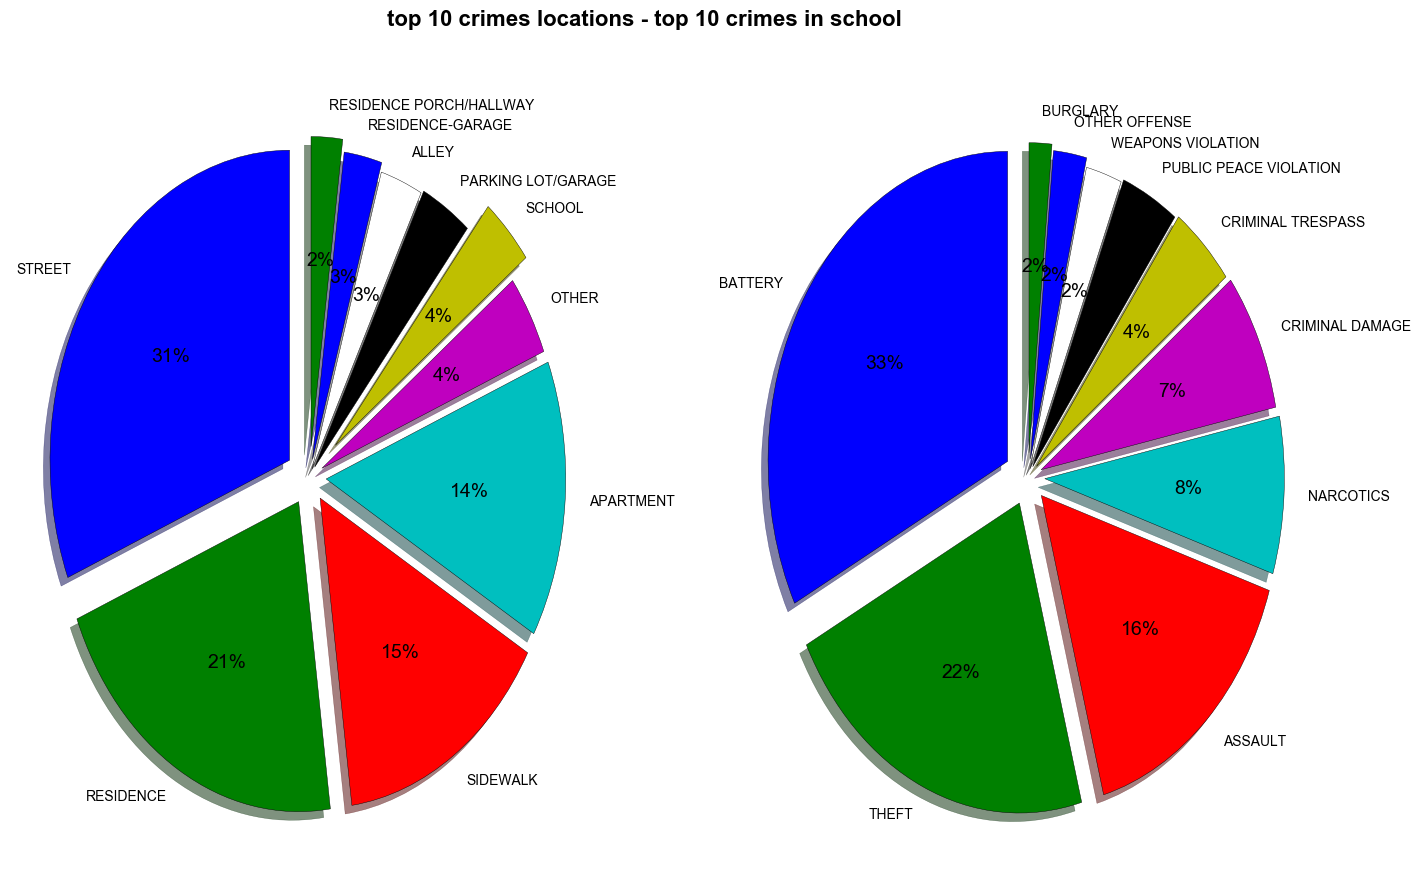

In [14]:
#LAYOUT
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2
 
labels_top10 = ['STREET', 'RESIDENCE','SIDEWALK','APARTMENT','OTHER','SCHOOL',
                 'PARKING LOT/GARAGE','ALLEY','RESIDENCE-GARAGE','RESIDENCE PORCH/HALLWAY']
fracs_top10 = [top10_loc[0][1], top10_loc[1][1], top10_loc[2][1], top10_loc[3][1], top10_loc[4][1],
                top10_loc[5][1], top10_loc[6][1], top10_loc[7][1], top10_loc[8][1], top10_loc[9][1]]
explode = [0.10,0.09,0.08,0.07,0.06, 0.15,0.04,0.03,0.06,0.10]
#------------
labels_schooltop10 = ['BATTERY','THEFT','ASSAULT', 'NARCOTICS','CRIMINAL DAMAGE',
                      'CRIMINAL TRESPASS','PUBLIC PEACE VIOLATION','WEAPONS VIOLATION','OTHER OFFENSE','BURGLARY']
fracs_schooltop10 =[top10_crim_sch[0][1], top10_crim_sch[1][1], top10_crim_sch[2][1], top10_crim_sch[3][1], top10_crim_sch[4][1],
                    top10_crim_sch[5][1], top10_crim_sch[6][1], top10_crim_sch[7][1], top10_crim_sch[8][1], top10_crim_sch[9][1]]
explode_school = [0.10,0.09,0.08,0.07,0.06, 0.05,0.04,0.03,0.06,0.08]
 
fig = plt.figure(figsize=(17, 10))
fig.suptitle('top 10 crimes locations - top 10 crimes in school ', fontsize=16, fontweight='bold')
 
ax_top10 = fig.add_subplot(121)
ax_top10.pie(fracs_top10, explode=explode, labels=labels_top10, colors=('b','g','r','c','m','y','k','w','b','g'),
              autopct='%1.0f%%', shadow=True, startangle=90)
 
ax_top10 = fig.add_subplot(122)
ax_top10.pie(fracs_schooltop10, explode=explode_school, labels=labels_schooltop10, colors=('b','g','r','c','m','y','k','w','b','g'),
              autopct='%1.0f%%', shadow=True, startangle=90)

In [3]:
homicide_year_2009= (data.filter(lambda x: x[14]=="2009")
    .filter(lambda x: HMC in x)
    .map(lambda x: x[1])
    .map(lambda x: x.split(" ")).map(lambda x: x[0])
    .map(lambda x: x.split("/")).map(lambda x: x[0]) )

In [4]:
murder_jan= homicide_year_2009.filter(lambda x: '01' in x).count()
murder_feb= homicide_year_2009.filter(lambda x: '02' in x).count()
murder_maart= homicide_year_2009.filter(lambda x: '03' in x).count()
murder_april= homicide_year_2009.filter(lambda x: '04' in x).count()
murder_mei= homicide_year_2009.filter(lambda x: '05' in x).count()
murder_juni= homicide_year_2009.filter(lambda x: '06' in x).count()
murder_juli= homicide_year_2009.filter(lambda x: '07' in x).count()
murder_aug= homicide_year_2009.filter(lambda x: '08' in x).count()
murder_sept= homicide_year_2009.filter(lambda x: '09' in x).count()
murder_okt= homicide_year_2009.filter(lambda x: '10' in x).count()
murder_nov= homicide_year_2009.filter(lambda x: '11' in x).count()
murder_dec= homicide_year_2009.filter(lambda x: '12' in x).count()

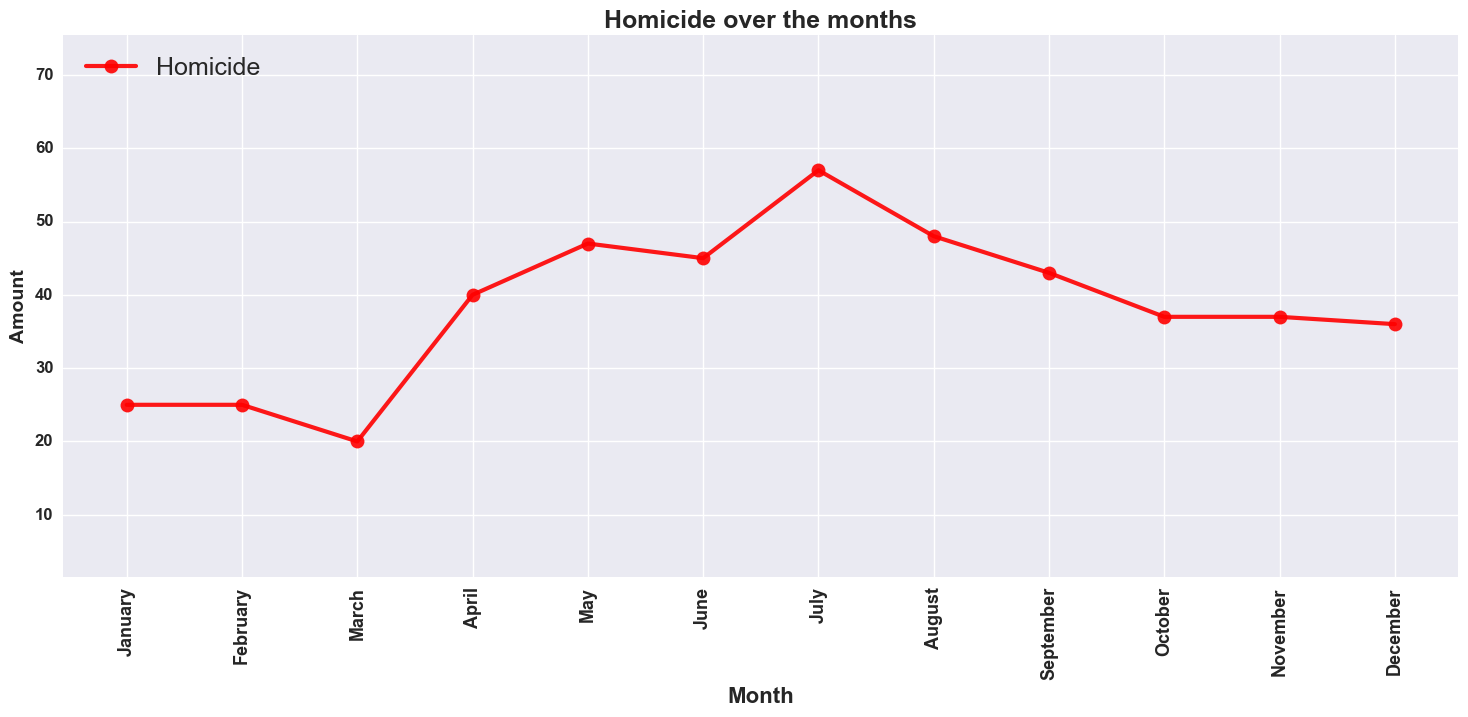

In [15]:
moorden_per_maand=[murder_jan, murder_feb, murder_maart, murder_april,
                   murder_mei, murder_juni, murder_juli, murder_aug,
                   murder_sept,murder_okt, murder_nov,murder_dec]
 
n_groups = (len(moorden_per_maand))
index = np.arange(1,n_groups+1) #die +1 dient ervoor om de grafiek beetje te verschuiven
xticklabels =('January','February','March','April','May','June','July',
         'August','September','October','November','December')
 
 
 
 
fig = plt.figure(figsize=(18,7))
plt.xticks(fontsize=12, fontweight='bold')  
plt.yticks(fontsize=12, fontweight='bold')
 
ax = fig.add_subplot(111)
rects= ax.plot(index, moorden_per_maand,
        color='r',
        alpha=0.9,
        marker='o',
        markersize=10,
        label ='Homicide',
        linewidth=3.0)
 
ax.set_xlabel('Month', fontsize=16, fontweight='bold')
ax.set_ylabel('Amount',  fontsize=14, fontweight='bold')
ax.set_title('Homicide over the months', fontsize = 18, fontweight='bold')
 
ticks_x = np.arange(1, 13, 1)
ticks_y = np.arange(0, 80, 10)  
ax.set_xticks(ticks_x)  
ax.set_xticklabels(xticklabels, rotation='vertical',fontsize=13, fontweight='bold')
ax.set_yticks(ticks_y)  
ax.margins(0.05,0.5)
 
#legende
ax.legend(prop={'size':18}, loc='upper left', shadow=True)
#print moorden_per_maand

In [14]:
prim_charges = data.map(lambda x: x[4]).distinct().collect()

years = data.map(lambda x: x[1].split('/')[2].split(' ')[0]).distinct().collect()


In [16]:
#PREPARING DYNAMIC HTML FORM

dynamic_crimes =""""""
for item in prim_charges:
    dynamic_crimes += "<option value={0}>{1}</option>\n".format('"'+item+'"',item)
    
dynamic_years =""""""
for item in years:
    dynamic_years += "<option value={0}>{1}</option>\n".format('"'+item+'"',item)

#INPUT FORM

from IPython.display import HTML

inp_year="-1"
inp_crime ="ASSAULT"

form = """
<div style='background-color:gainsboro; width:400px; padding:20px;'>
    Crime: 
    <br>
    <select id="crime" name ="crime" onchange='set_vars()'>
        %s
    </select>
    <hr>
    Year: 
    <br>
    <select id="year" name ="year" onchange='set_vars()'>
        <option value=-1>All</option>
        %s
    </select>
</div>
"""
javascript = """
<script type="text/Javascript">
    function set_vars(){
        var command_year = "inp_year ='"+document.getElementById('year').value+"'";
        var command_crime = "inp_crime ='"+document.getElementById('crime').value+"'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command_year);
        kernel.execute(command_crime);
        cell = IPython.notebook.get_cell(18);
        cell.execute();
        cell.focus_cell();
    }
</script>
"""

HTML(form %(dynamic_crimes,dynamic_years) + javascript)

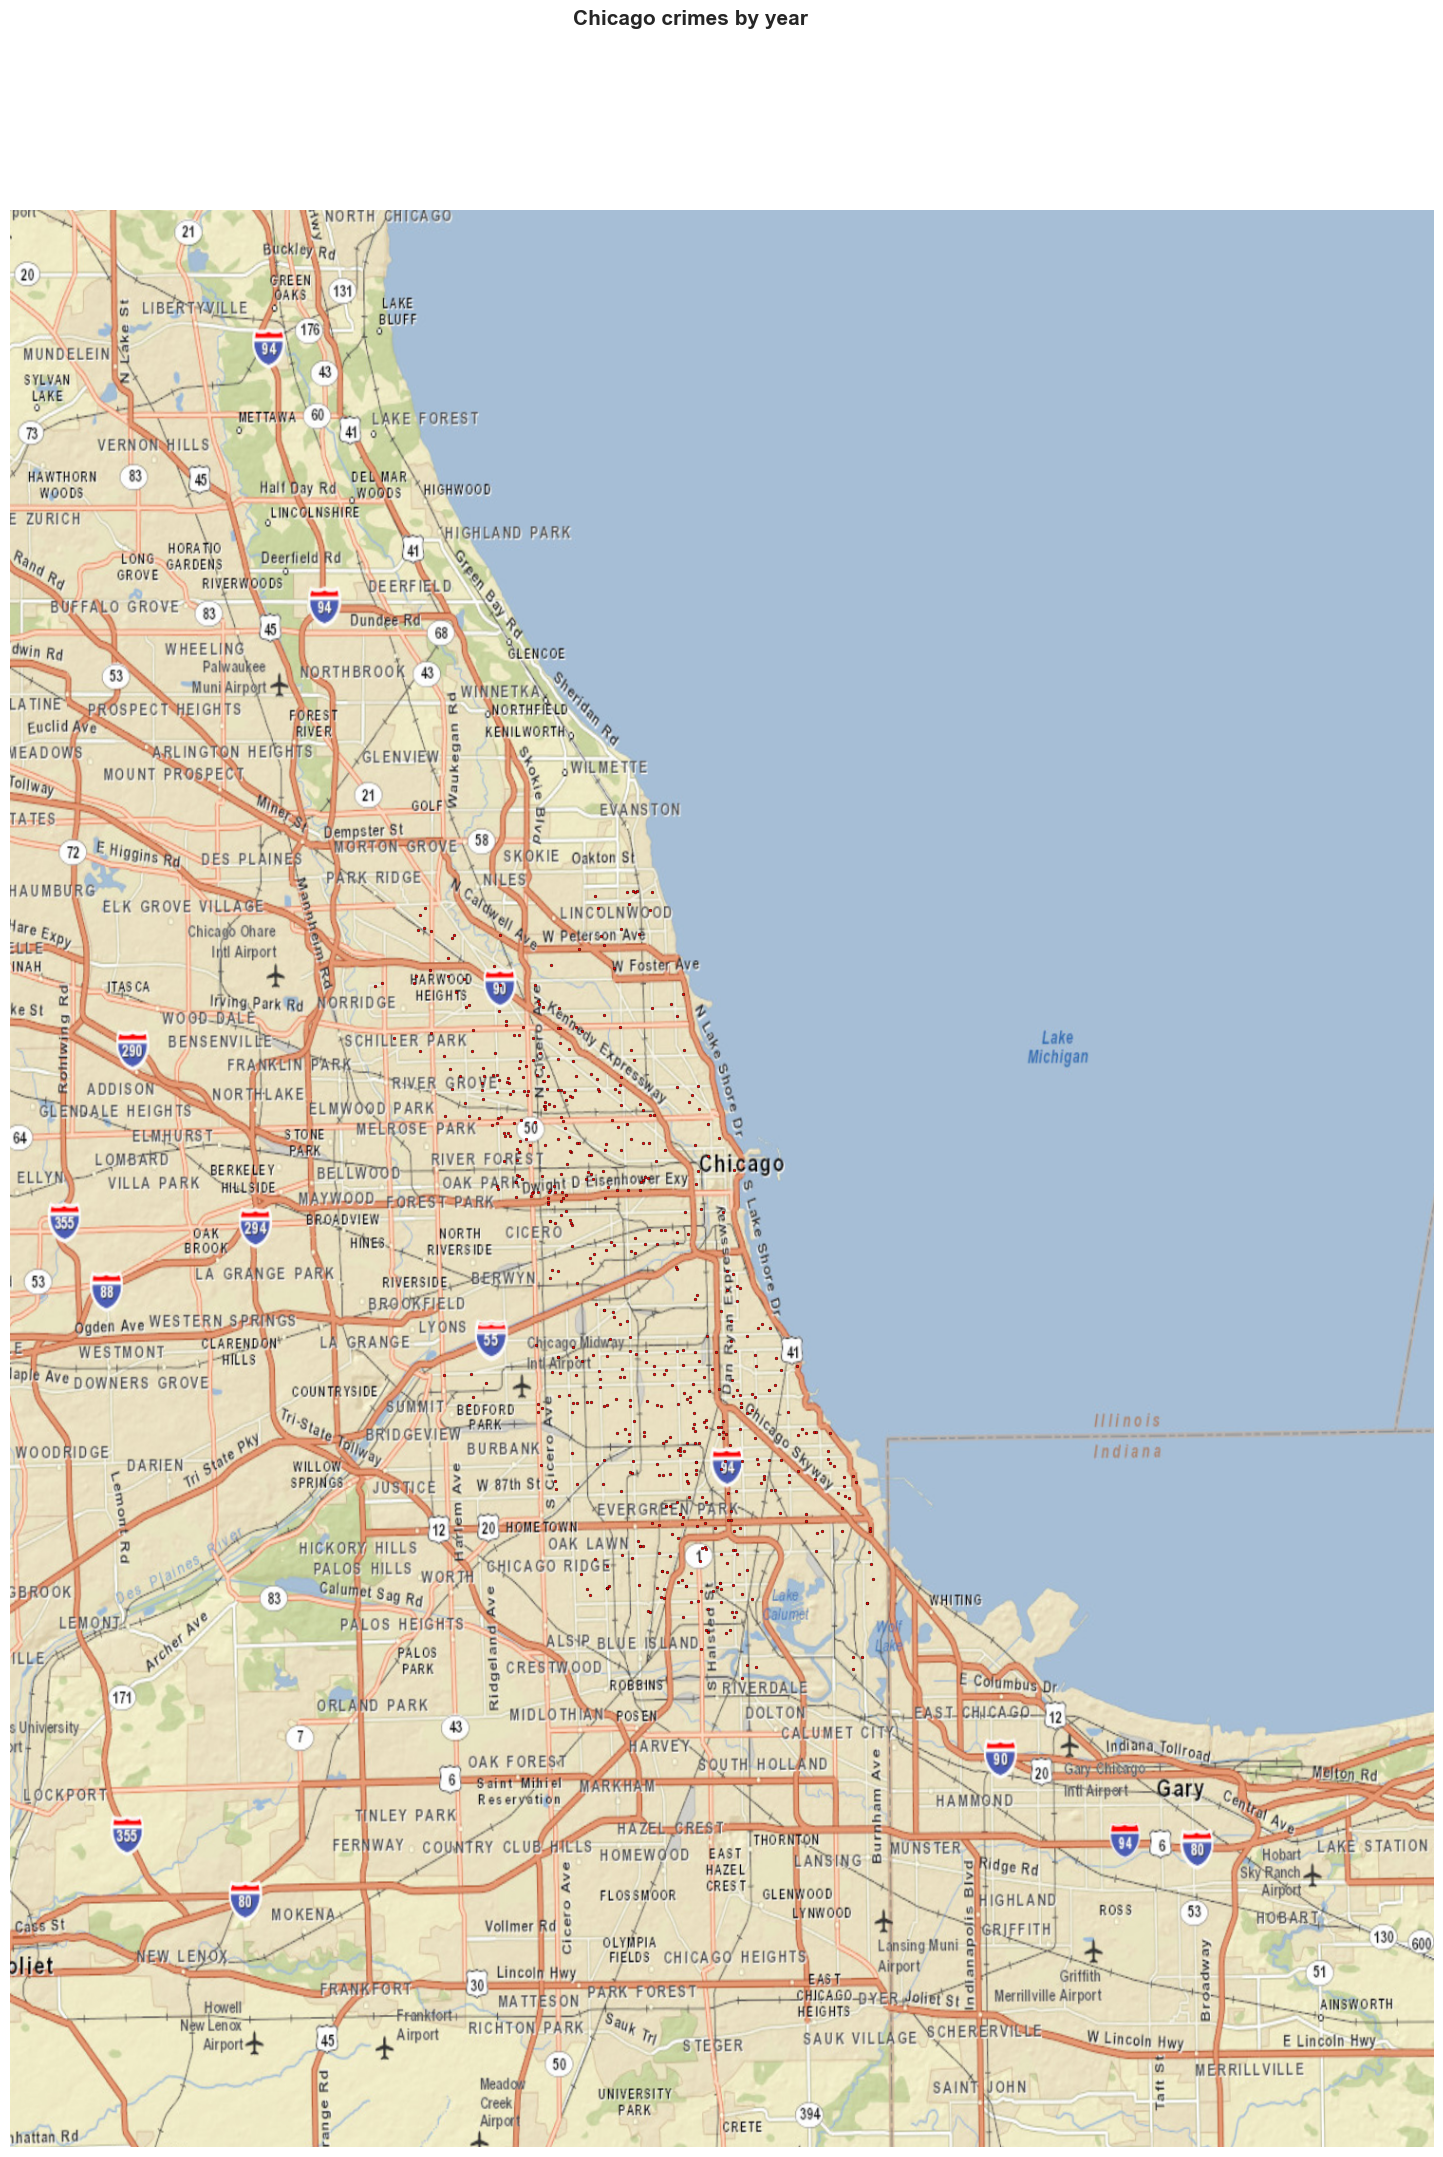

In [21]:

center = [-87.623177,41.881832]
zoomrate = 0.3
lon_range = zoomrate*3
lat_range = zoomrate*3
c1 = center[0] - (lon_range / 2)
c2 = center[1] - (lat_range / 2)
c3 = center[0] + (lon_range / 2)
c4 = center[1] + (lat_range / 2)


fig = plt.figure(figsize=(25, 25))
fig.suptitle('Chicago crimes by year', fontsize=15, fontweight='bold')
fig.add_subplot(111)
             
map = Basemap(llcrnrlon=c1,llcrnrlat=c2,urcrnrlon=c3,urcrnrlat=c4, epsg=3435)

map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels = 1500, verbose= False)

if inp_year == "-1":
    filtered_data = getDataByCrime(inp_crime)
else:
    filtered_data = getDataByCrimeAndYear(inp_crime,inp_year)

    
lons = []
lats = []
for item in filtered_data:    
    if item[15]!='' and item[16]!='':
        lons.append(float(item[16]))
        lats.append(float(item[15]))
    
x, y = map(lons, lats)
map.scatter(x, y, s=4, c='r', marker='o')
    
plt.show()

In [9]:
#AVERAGE TIME BETWEEN CRIMES


for pc in prim_charges:
    
    seconds = None
    count = 0
    last_date = None
    cd = None
    
    filtered_data_list = getDataByCrime(pc)
    
    for crime in filtered_data_list:
        cd = datetime.strptime(str(crime[1]),'%m/%d/%Y %I:%M:%S %p')
        
        if count == 0:
            seconds = 0
            
        else:
            seconds += (cd-last_date).total_seconds()
            
        last_date = cd
        count+=1
        
    print(pc +": "+time.strftime('%Hh %Mm', time.gmtime(abs(int(seconds))/count))+"("+str(count)+")")

ASSAULT: 00h 02m(44396)
KIDNAPPING: 05h 24m(606)
ROBBERY: 00h 10m(30252)
CRIM SEXUAL ASSAULT: 02h 03m(2741)
OTHER NARCOTIC VIOLATION: 03h 04m(13)
SEX OFFENSE: 02h 18m(2352)
PROSTITUTION: 00h 57m(6425)
MOTOR VEHICLE THEFT: 00h 11m(34510)
LIQUOR LAW VIOLATION: 04h 33m(1482)
CRIMINAL TRESPASS: 00h 19m(20252)
OTHER OFFENSE: 00h 10m(47612)
GAMBLING: 03h 31m(1918)
BURGLARY: 00h 05m(53187)
HOMICIDE: 17h 17m(898)
STALKING: 09h 05m(356)
NON-CRIMINAL: 12h 30m(2)
OFFENSE INVOLVING CHILDREN: 02h 09m(5058)
OBSCENITY: 07h 06m(54)
DECEPTIVE PRACTICE: 00h 25m(26132)
ARSON: 01h 14m(1138)
PUBLIC INDECENCY: 11h 01m(17)
BATTERY: 00h 04m(133865)
PUBLIC PEACE VIOLATION: 00h 53m(6685)
INTERFERENCE WITH PUBLIC OFFICER: 02h 36m(1369)
NARCOTICS: 00h 06m(86936)
CRIMINAL DAMAGE: 00h 08m(88377)
INTIMIDATION: 01h 08m(428)
THEFT: 00h 03m(157722)
WEAPONS VIOLATION: 00h 50m(7862)


In [2]:
def kmBetweenCoords(lon1, lat1, lon2, lat2):
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians,[lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [3]:
from math import radians, cos, sin, asin, sqrt

pdd = defaultdict(lambda:0)
 
policestation_count = policestation_data.count()  
counter = 0
errors = 0

for policestation in policestation_data.collect():
    counter+=1
    if len(policestation)!=16:
        errors += 1
        continue

    clear_output()
    print('[{0}({1})/{2}]'.format(counter,errors,policestation_count))

    for crime in data.collect():   
        if crime[15]!='' and crime[16]!='':
            lat1 = float(policestation[12])
            lon1 = float(policestation[13])
            lat2 = float(crime[15])
            lon2 = float(crime[16])
            if kmBetweenCoords(lat1,lon1,lat2,lon2) < 0.2:
                pdd[policestation[1]]+=1

                
clear_output()
for item in sorted(pdd.items(), key=operator.itemgetter(1), reverse=True):
    print '{0}: {1}'.format(item[0],item[1])

Central: 10849
Grand Crossing: 8340
Gresham: 7163
Grand Central: 7064
Englewood: 6259
Harrison: 6202
Headquarters: 5097
Ogden: 5067
Town Hall: 4983
Near North: 4422
Shakespeare: 3861
Rogers Park: 3503
Austin: 3409
Wentworth: 2970
Albany Park: 2731
Deering: 2554
Lincoln: 1933
Calumet: 1858
Jefferson Park: 1812
Chicago Lawn: 1659
South Chicago: 1490
Morgan Park: 1126
